# Instacart Market Basket Analysis: Customer Segmentation
*Date: 2025-05*  

**Objective**: Segment Instacart customers into distinct behavioral-demographic clusters for targeted marketing.

### Contents:

     1. Data Loading & Preprocessing
     2. Exploratory Data Analysis
     3. Feature Creation
     4. Demographic Analysis
     5. Clustering Analysis
     6. Cluster Profiling
     7. Interactive 3D Visualization
     8. Business Recommendations

## 1. Data Loading & Preprocessing

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
import plotly.express as px
import os

In [3]:
# Set path
path = r'~/Data/'
# Load datasets
orders = pd.read_csv(os.path.join(path, 'orders.csv'))
order_products = pd.read_csv(os.path.join(path, 'orders_products_prior.csv'))
products = pd.read_csv(os.path.join(path, 'products.csv'))
departments = pd.read_csv(os.path.join(path, 'departments.csv'))
customer = pd.read_csv(os.path.join(path, 'customers.csv'))

In [5]:
# Merge datasets
df = orders.merge(order_products, on='order_id').merge(products, on='product_id')

## 2. Exploratory Data Analysis

#### Key Questions:

 * What are the best-selling products?
 * When do customers spend the most money?
 * When are the best times to schedule ads?
 * What differences exist in the ordering habits of different customer profiles?


In [9]:
# Group total sales by department name in descending order, save as dataframe
df_dept = df.merge(departments, on='department_id')
df_deptsales = df_dept.groupby('department')['prices'].sum().sort_values(ascending=False).to_frame()
print(df_deptsales.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, produce to other
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prices  21 non-null     float64
dtypes: float64(1)
memory usage: 336.0+ bytes
None


Text(0.5, 0, 'Sales')

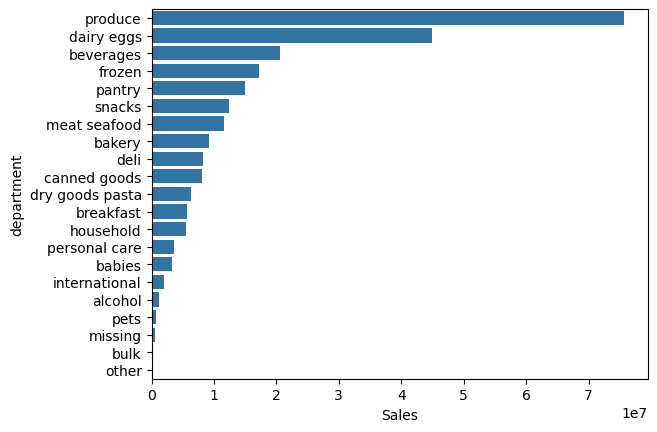

In [11]:
# Create bar plot showing total sales by department name
deptsalesbar = sns.barplot(y = 'department', x = 'prices', data = df_deptsales)
deptsalesbar.set_xlabel('Sales')

In [89]:
prodsales = df.groupby('product_name')['order_id'].count().sort_values(ascending=False).to_frame()
print(prodsales.head())
prodsales=prodsales.head(20)

                        order_id
product_name                    
Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584


Text(0.5, 0, 'Number of Orders')

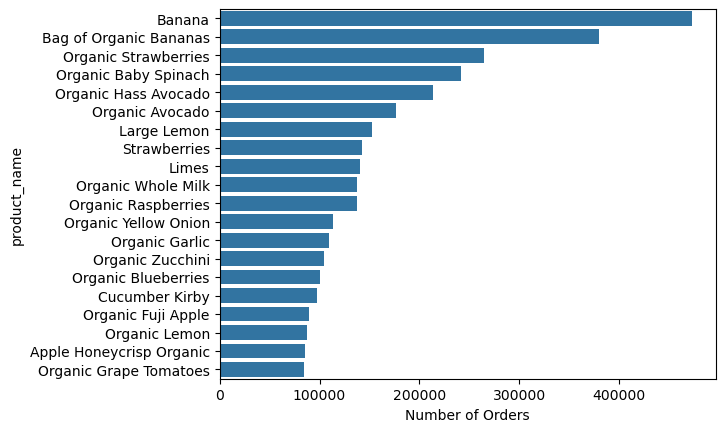

In [95]:
# Create bar plot showing total sales by product
prodsalesbar = sns.barplot(y = 'product_name', x = 'order_id', data = prodsales)
prodsalesbar.set_xlabel('Number of Orders')

In [86]:
# Group number of orders by hour of day, save as dataframe
hourcount = df.groupby(['order_hour_of_day'])['order_id'].count().to_frame()
print(hourcount)

                   order_id
order_hour_of_day          
0                    218766
1                    115699
2                     69374
3                     51281
4                     53241
5                     87959
6                    290492
7                    891040
8                   1718100
9                   2454165
10                  2761710
11                  2736075
12                  2618481
13                  2660900
14                  2689086
15                  2662094
16                  2535154
17                  2087609
18                  1636469
19                  1258290
20                   976145
21                   795628
22                   634216
23                   402315


Text(0, 0.5, 'Number of Orders')

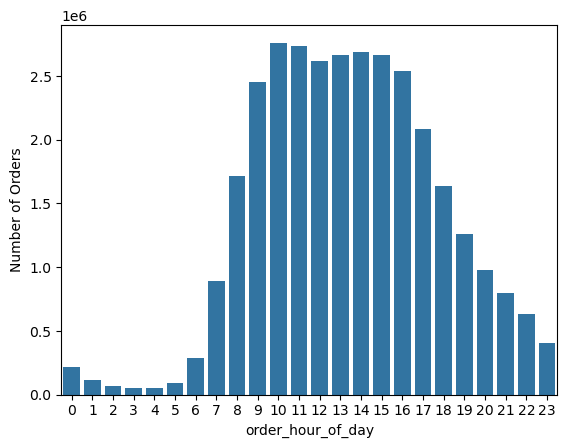

In [88]:
# Create bar chart showing total sales by hour of day
hourlycountbar = sns.barplot(x = 'order_hour_of_day', y = 'order_id', data = hourcount)
hourlycountbar.set_ylabel('Number of Orders')

In [81]:
# Group number of orders by hour of day, save as dataframe
dowcount = df.groupby(['order_dow'])['order_id'].count().to_frame()
print(dowcount)

           order_id
order_dow          
0           6204040
1           5660135
2           4213760
3           3840476
4           3783754
5           4205721
6           4496403


<function matplotlib.pyplot.show(close=None, block=None)>

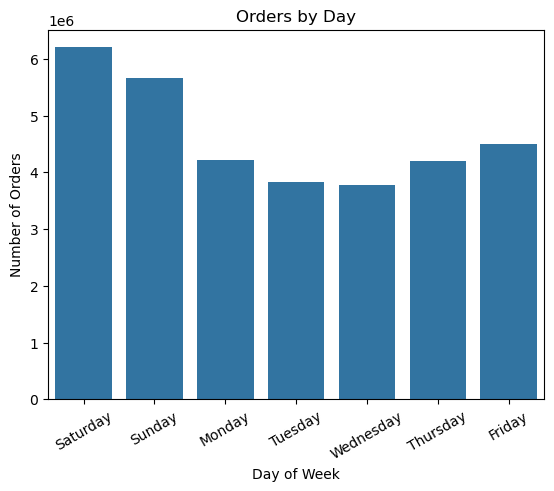

In [83]:
# Create bar chart showing total sales by hour of day
dowcountbar = sns.barplot(x = 'order_dow', y = 'order_id', data = dowcount)
dowcountbar.set_ylabel('Number of Orders')
dowcountbar.set_xlabel('Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
          rotation=30)
plt.title('Orders by Day')
plt.show

In [13]:
heat_data = df.groupby(['order_dow', 'order_hour_of_day'])['order_id'].count().unstack()

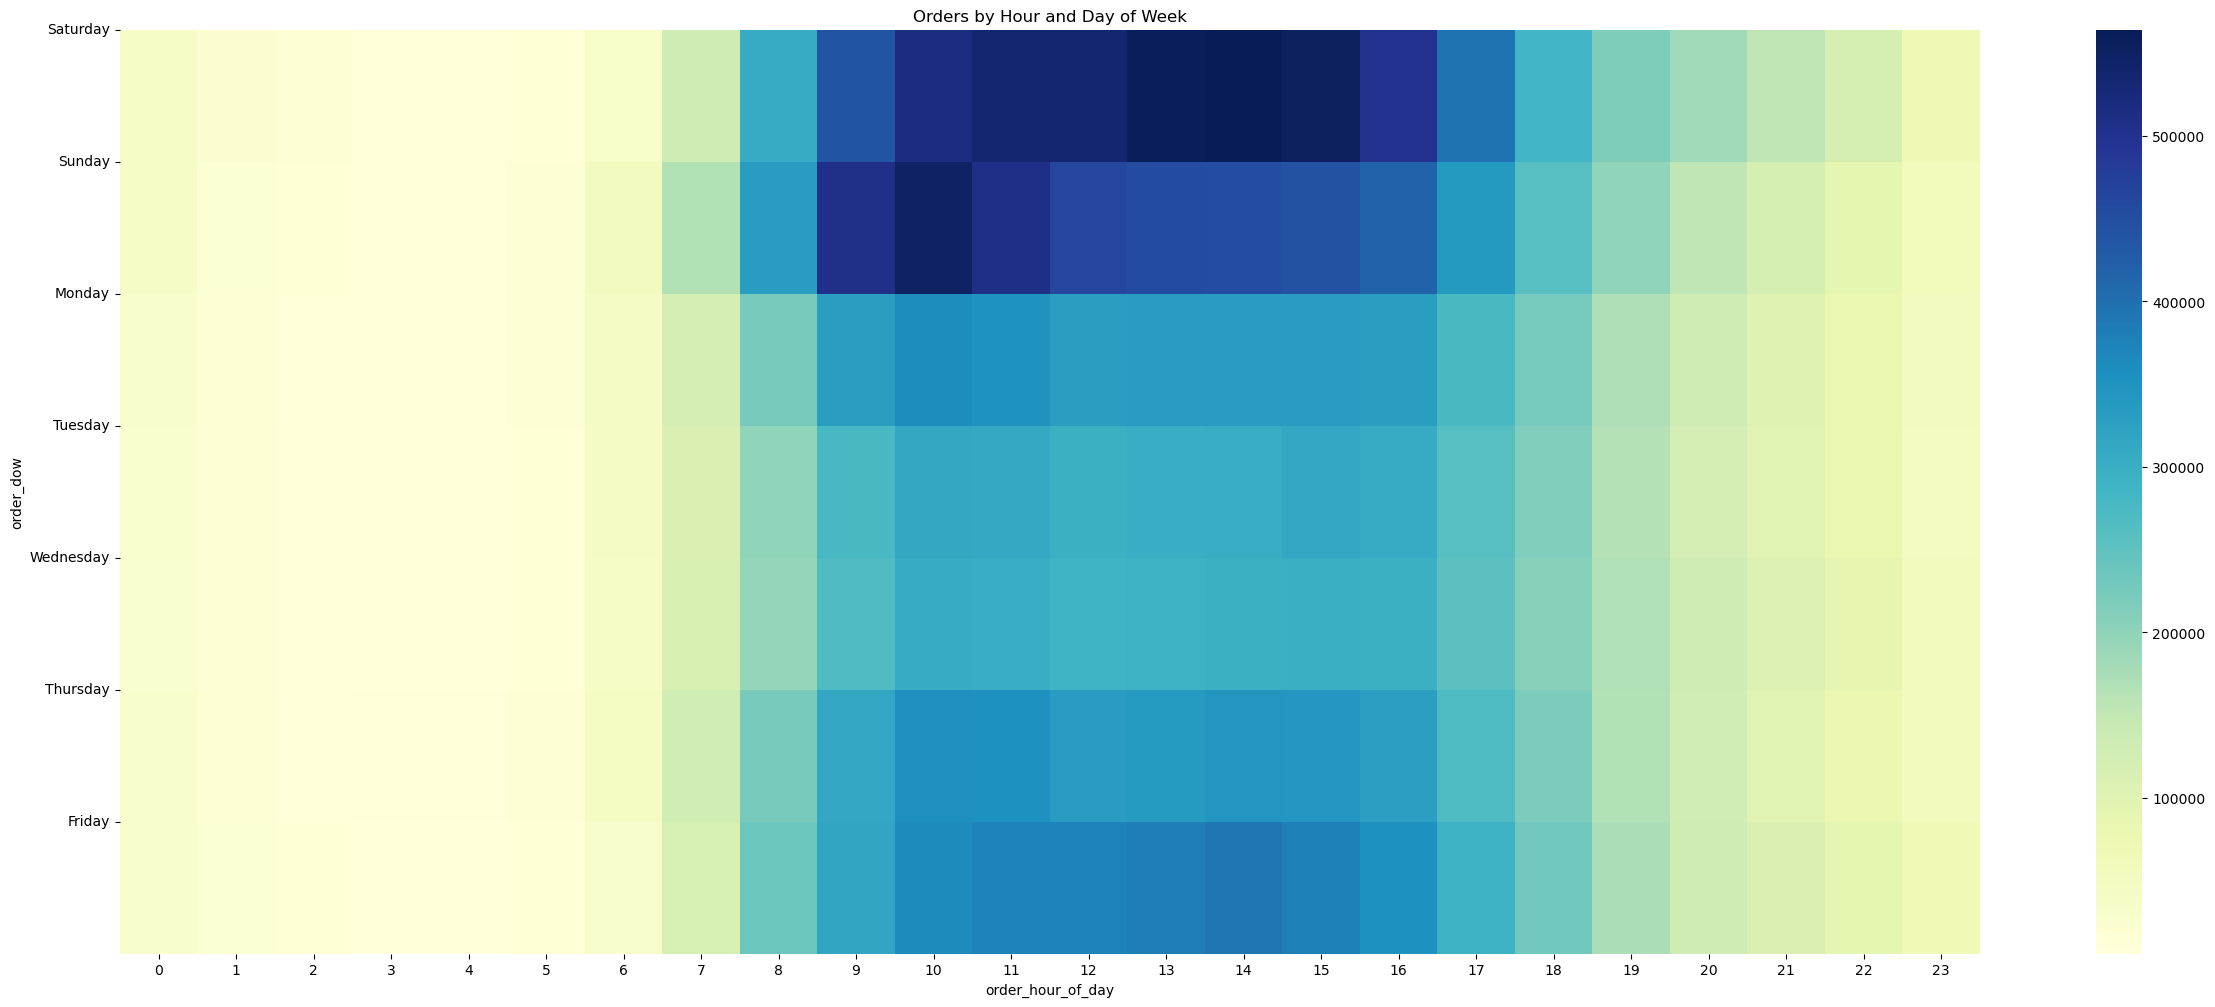

In [99]:
# Visualize sales by hour and day of week
plt.figure(figsize=(30,12))
sns.heatmap(
    heat_data,
    cmap='YlGnBu'
)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
          rotation=0)
plt.title('Orders by Hour and Day of Week')
plt.show()

## 3. Feature Creation

In [45]:
print(df.isnull().sum())

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2076062
no_prior_orders                 0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
prices                       5127
dtype: int64


In [7]:
# Calculate customer-level features
customer_features = df.groupby('user_id').agg(
    order_count=('order_id', 'count'),
    avg_days_between_orders=('days_since_prior_order', 'mean'),
    uniq_prod=('product_id', 'nunique'),
    total_spent=('prices', 'sum'),
    weekend_order_ratio=('order_dow', lambda x: (x.isin([0,1]).mean())
                         )).reset_index()

In [49]:
print(customer_features.isnull().sum())

user_id                    0
order_count                0
avg_days_between_orders    1
uniq_prod                  0
total_spent                0
weekend_order_ratio        0
dtype: int64


In [8]:
customer_features = customer_features[customer_features['avg_days_between_orders'].isnull()==False]
print(customer_features.isnull().sum())

user_id                    0
order_count                0
avg_days_between_orders    0
uniq_prod                  0
total_spent                0
weekend_order_ratio        0
dtype: int64


In [11]:
# Calculate product preferences
dept_preferences = df.groupby(['user_id','department_id']).agg(
    dept_purchases=('product_id','count')
).reset_index()
dept_preferences['dept_rank'] = dept_preferences.groupby('user_id')['dept_purchases'].rank(ascending=False)
preferred_dept = dept_preferences[dept_preferences['dept_rank']==1][['user_id','department_id']]

In [57]:
# Check preferred_dept
print(preferred_dept.shape)
print(preferred_dept.info())

(196139, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 196139 entries, 6 to 2232138
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   user_id        196139 non-null  int64
 1   department_id  196139 non-null  int64
dtypes: int64(2)
memory usage: 4.5 MB
None


In [13]:
# Calculate basket metrics
basket_stats = df.groupby(['user_id','order_id']).agg(
    basket_size=('product_id','count'),
    reorder_ratio=('reordered','mean')
).groupby('user_id').mean().reset_index()

In [61]:
# Check basket_stats
print(basket_stats.shape)
print(basket_stats.info())

(206210, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206210 entries, 0 to 206209
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        206210 non-null  int64  
 1   basket_size    206210 non-null  float64
 2   reorder_ratio  206210 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 4.7 MB
None


In [15]:
# Merge all features
df_final = customer_features.merge(basket_stats, on='user_id').merge(preferred_dept, on='user_id').merge(departments, on='department_id')

In [81]:
# Check df_final
print(df_final.shape)
print(df_final.info())
print(df_final.head())

(196138, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196138 entries, 0 to 196137
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  196138 non-null  int64  
 1   order_count              196138 non-null  int64  
 2   avg_days_between_orders  196137 non-null  float64
 3   uniq_prod                196138 non-null  int64  
 4   total_spent              196138 non-null  float64
 5   weekend_order_ratio      196138 non-null  float64
 6   basket_size              196138 non-null  float64
 7   reorder_ratio            196138 non-null  float64
 8   department_id            196138 non-null  int64  
 9   department               196138 non-null  object 
dtypes: float64(5), int64(4), object(1)
memory usage: 15.0+ MB
None
   user_id  order_count  avg_days_between_orders  uniq_prod  total_spent  \
0        1           59                20.259259         18        375.7

In [17]:
# Merge with customer data
customer_details = df_final.merge(customer, on='user_id')
print(customer_details.shape)
print(customer_details.info())

(196137, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196137 entries, 0 to 196136
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  196137 non-null  int64  
 1   order_count              196137 non-null  int64  
 2   avg_days_between_orders  196137 non-null  float64
 3   uniq_prod                196137 non-null  int64  
 4   total_spent              196137 non-null  float64
 5   weekend_order_ratio      196137 non-null  float64
 6   basket_size              196137 non-null  float64
 7   reorder_ratio            196137 non-null  float64
 8   department_id            196137 non-null  int64  
 9   department               196137 non-null  object 
 10  first_name               185422 non-null  object 
 11  last_name                196137 non-null  object 
 12  gender                   196137 non-null  object 
 13  state                    196137 non-null  obje

## 4. Demographic Analysis

In [177]:
# Create five-year age bracket column
customer_details.loc[customer_details['age'] <= 25, 'age_bracket'] = '25 and Under'

In [21]:
customer_details.loc[(customer_details['age'] > 25) & (customer_details['age'] <=30), 'age_bracket'] = '26-30'

In [23]:
customer_details.loc[(customer_details['age'] > 30) & (customer_details['age'] <=35), 'age_bracket'] = '31-35'

In [25]:
customer_details.loc[(customer_details['age'] > 35) & (customer_details['age'] <=40), 'age_bracket'] = '36-40'

In [27]:
customer_details.loc[(customer_details['age'] > 40) & (customer_details['age'] <=45), 'age_bracket'] = '41-45'

In [29]:
customer_details.loc[(customer_details['age'] > 45) & (customer_details['age'] <=50), 'age_bracket'] = '46-50'

In [31]:
customer_details.loc[(customer_details['age'] > 50) & (customer_details['age'] <=55), 'age_bracket'] = '51-55'

In [33]:
customer_details.loc[(customer_details['age'] > 55) & (customer_details['age'] <=60), 'age_bracket'] = '56-60'

In [35]:
customer_details.loc[(customer_details['age'] > 60) & (customer_details['age'] <=65), 'age_bracket'] = '61-65'

In [37]:
customer_details.loc[(customer_details['age'] > 65) & (customer_details['age'] <=70), 'age_bracket'] = '66-70'

In [39]:
customer_details.loc[(customer_details['age'] > 70) & (customer_details['age'] <=75), 'age_bracket'] = '71-75'

In [179]:
customer_details.loc[customer_details['age'] > 75, 'age_bracket'] = '75+'

In [181]:
# Select relevant columns for age_bracket analysis
avgs_by_age = customer_details[['age_bracket', 'order_count','avg_days_between_orders', 'weekend_order_ratio', 'age', 'income', 'total_spent', 'uniq_prod',
              'basket_size','reorder_ratio']]
# Analyze group characteristics
profiles = avgs_by_age.groupby('age_bracket').mean().round(2)
print(profiles)

              order_count  avg_days_between_orders  weekend_order_ratio  \
age_bracket                                                               
25 and Under       162.86                    15.31                 0.36   
26-30              162.34                    15.40                 0.36   
31-35              163.93                    15.37                 0.36   
36-40              163.65                    15.27                 0.36   
41-45              161.25                    15.34                 0.36   
46-50              163.11                    15.39                 0.36   
51-55              161.63                    15.24                 0.36   
56-60              162.26                    15.38                 0.36   
61-65              161.13                    15.39                 0.36   
66-70              162.14                    15.25                 0.36   
71-75              161.67                    15.31                 0.36   
75+                162.11

In [183]:
spent_by_age = customer_details.groupby(['age_bracket'])['total_spent'].sum().to_frame().reset_index()
spent_by_age

age_bracket  total_spent
0   25 and Under   30948792.6
1          26-30   19520686.5
2          31-35   19493588.0
3          36-40   19330752.5
4          41-45   19397120.9
5          46-50   19620172.1
6          51-55   19485055.3
7          56-60   19196519.9
8          61-65   19146400.2
9          66-70   19223871.5
10         71-75   19389895.0
11           75+   23350018.1

Axes(0.125,0.11;0.775x0.77)


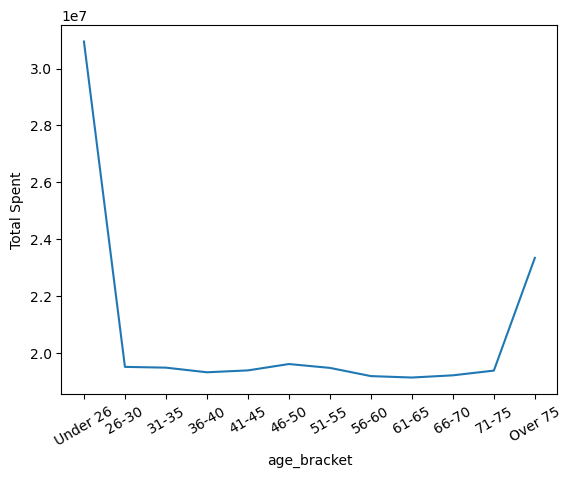

In [61]:
# Create line chart
line = sns.lineplot(data = spent_by_age, x = 'age_bracket',y = 'total_spent')
plt.ylabel('Total Spent')
plt.xticks(rotation=30)
print(line)

In [185]:
avg_spent_by_age = customer_details.groupby(['age_bracket'])['total_spent'].mean().to_frame().reset_index()

avg_spent_by_age

age_bracket  total_spent
0   25 and Under  1268.029360
1          26-30  1262.412630
2          31-35  1277.346701
3          36-40  1275.031495
4          41-45  1257.593419
5          46-50  1272.632296
6          51-55  1255.804028
7          56-60  1264.509578
8          61-65  1257.232924
9          66-70  1264.312496
10         71-75  1260.721391
11           75+  1262.640897

Axes(0.125,0.11;0.775x0.77)


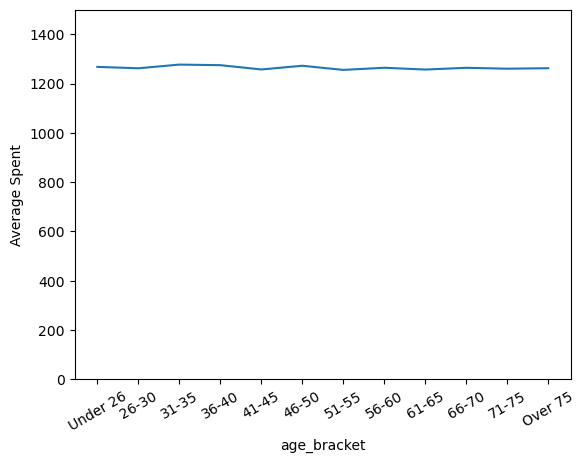

In [113]:
# Create line chart
line = sns.lineplot(data = avg_spent_by_age, x = 'age_bracket',y = 'total_spent')
plt.ylim(bottom=0, top=1500)
plt.ylabel('Average Spent')
plt.xticks(rotation=30)
print(line)

In [189]:
# Get top 2 departments per age group
top_depts_per_age_grp = (customer_details.groupby(['age_bracket', 'department'])
                         .size()
                         .reset_index(name='count')
                         .sort_values(['age_bracket', 'count'], ascending=[True, False])
                         .groupby('age_bracket')
                         .head(2))
# Pivot for clean presentation
result = (top_depts_per_age_grp.pivot(index='age_bracket', 
                                    columns='department', 
                                    values='count')
                              .fillna(0)
                              .apply(lambda x: x.sort_values(ascending=False).index[:2], axis=1)
                              .reset_index(name='top_departments'))

# Format output
result['top_departments'] = result['top_departments'].apply(lambda x: f"{x[0]}, {x[1]}")

print("Top 2 Departments per Age Group:")
print(result.to_markdown(index=False))

Top 2 Departments per Age Group:
| age_bracket   | top_departments     |
|:--------------|:--------------------|
| 25 and Under  | produce, dairy eggs |
| 26-30         | produce, dairy eggs |
| 31-35         | produce, dairy eggs |
| 36-40         | produce, dairy eggs |
| 41-45         | produce, dairy eggs |
| 46-50         | produce, dairy eggs |
| 51-55         | produce, dairy eggs |
| 56-60         | produce, dairy eggs |
| 61-65         | produce, dairy eggs |
| 66-70         | produce, dairy eggs |
| 71-75         | produce, dairy eggs |
| 75+           | produce, dairy eggs |


In [119]:
customer_details.loc[customer_details['income'] <= 50000, 'income_bracket'] = '0 - 50k'

In [121]:
customer_details.loc[(customer_details['income'] > 50000) & (customer_details['income'] <=100000), 'income_bracket'] = '050k-100k'

In [123]:
customer_details.loc[(customer_details['income'] > 100000) & (customer_details['income'] <=150000), 'income_bracket'] = '100k-150k'

In [125]:
customer_details.loc[(customer_details['income'] > 150000) & (customer_details['income'] <=200000), 'income_bracket'] = '150k-200k'

In [127]:
customer_details.loc[(customer_details['income'] > 200000) & (customer_details['income'] <=250000), 'income_bracket'] = '200k-250k'

In [129]:
customer_details.loc[(customer_details['income'] > 250000) & (customer_details['income'] <=300000), 'income_bracket'] = '250k-300k'

In [131]:
customer_details.loc[(customer_details['income'] > 300000) & (customer_details['income'] <=350000), 'income_bracket'] = '300k-350k'

In [133]:
customer_details.loc[(customer_details['income'] > 350000) & (customer_details['income'] <=400000), 'income_bracket'] = '350k-400k'

In [135]:
customer_details.loc[(customer_details['income'] > 400000) & (customer_details['income'] <=450000), 'income_bracket'] = '400k-450k'

In [137]:
customer_details.loc[(customer_details['income'] > 450000) & (customer_details['income'] <=500000), 'income_bracket'] = '450k-500k'

In [139]:
customer_details.loc[(customer_details['income'] > 500000) & (customer_details['income'] <=550000), 'income_bracket'] = '500k-550k'

In [141]:
customer_details.loc[customer_details['income'] > 550000, 'income_bracket'] = '550k+'

In [153]:
# Select relevant columns for income_grp analysis
avgs_by_income = customer_details[['income_bracket', 'order_count','avg_days_between_orders', 'weekend_order_ratio', 'age', 'income', 'total_spent', 'uniq_prod',
              'basket_size','reorder_ratio']]
# Analyze group characteristics
profiles2 = avgs_by_income.groupby('income_bracket').mean().round(2)
print(profiles2)

                order_count  avg_days_between_orders  weekend_order_ratio  \
income_bracket                                                              
0 - 50k              109.81                    16.17                 0.34   
050k-100k            170.26                    15.22                 0.37   
100k-150k            173.27                    15.15                 0.36   
150k-200k            175.26                    15.00                 0.36   
200k-250k            255.70                    12.87                 0.35   
250k-300k            264.22                    13.60                 0.36   
300k-350k            285.65                    12.84                 0.32   
350k-400k            264.18                    13.84                 0.34   
400k-450k            315.60                    12.53                 0.35   
450k-500k            190.60                    14.78                 0.33   
500k-550k            227.19                    14.50                 0.35   

In [145]:
spent_by_income = customer_details.groupby(['income_bracket'])['total_spent'].sum().to_frame().reset_index()
spent_by_income

income_bracket  total_spent
0         0 - 50k   23488366.5
1       050k-100k  108688091.7
2       100k-150k   84313122.3
3       150k-200k   29659394.6
4       200k-250k     574857.7
5       250k-300k     618611.7
6       300k-350k     196043.1
7       350k-400k     202603.8
8       400k-450k     144268.8
9       450k-500k      69534.8
10      500k-550k      72887.1
11          550k+      75090.5

Axes(0.125,0.11;0.775x0.77)


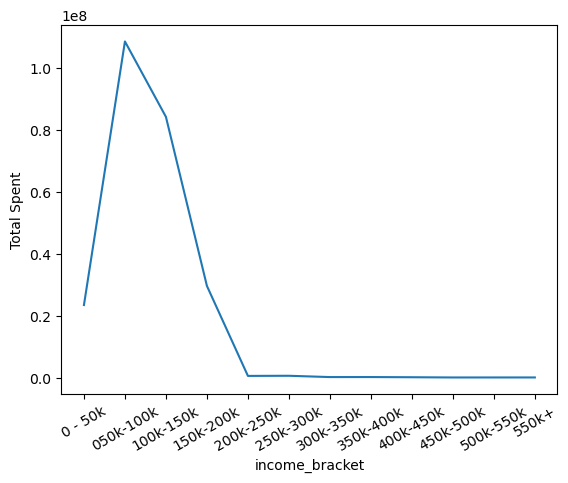

In [147]:
# Create line chart
spentincomeline = sns.lineplot(data = spent_by_income, x = 'income_bracket',y = 'total_spent')
plt.ylabel('Total Spent')
plt.xticks(rotation=30)
print(spentincomeline)

In [149]:
avg_spent_by_income = customer_details.groupby(['income_bracket'])['total_spent'].mean().to_frame().reset_index()

avg_spent_by_income.head()

income_bracket  total_spent
0        0 - 50k   735.781928
1      050k-100k  1343.918833
2      100k-150k  1379.739515
3      150k-200k  1394.292713
4      200k-250k  1968.690753

Axes(0.125,0.11;0.775x0.77)


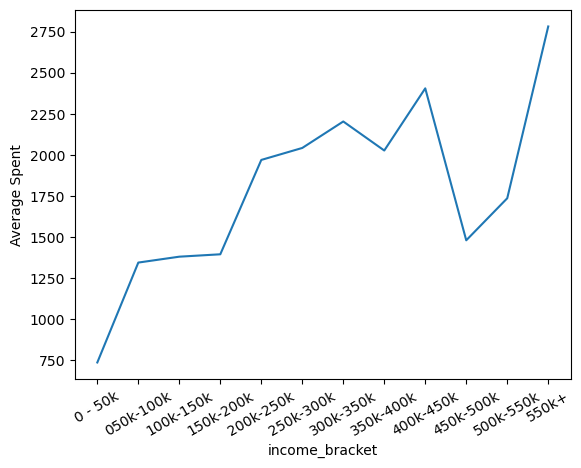

In [151]:
line = sns.lineplot(data = avg_spent_by_income, x = 'income_bracket',y = 'total_spent')
plt.ylabel('Average Spent')
plt.xticks(rotation=30)
print(line)

Axes(0.125,0.11;0.775x0.77)


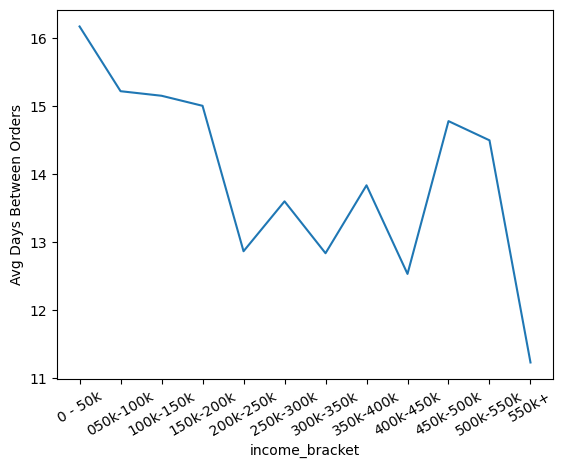

In [191]:
orderfreq = customer_details.groupby(['income_bracket'])['avg_days_between_orders'].mean().to_frame().reset_index()
orderfreqline = sns.lineplot(data = orderfreq, x = 'income_bracket',y = 'avg_days_between_orders')
plt.ylabel('Avg Days Between Orders')
plt.xticks(rotation=30)
print(orderfreqline)

Axes(0.125,0.11;0.775x0.77)


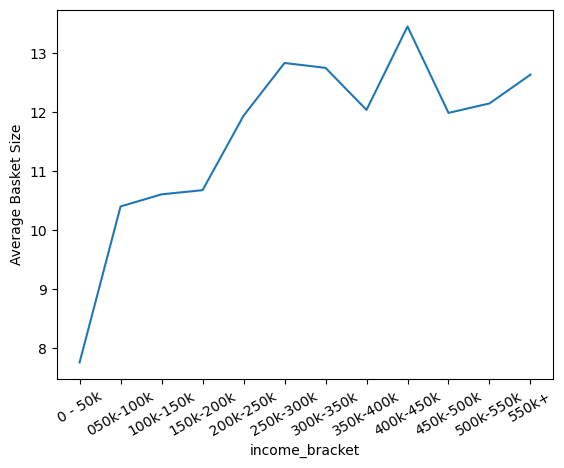

In [193]:
basketsize = customer_details.groupby(['income_bracket'])['basket_size'].mean().to_frame().reset_index()
basketsizeline = sns.lineplot(data = basketsize, x = 'income_bracket',y = 'basket_size')
plt.ylabel('Average Basket Size')
plt.xticks(rotation=30)
print(basketsizeline)

In [165]:
# Get top 2 departments per income group
top_depts_per_income_grp = (customer_details.groupby(['income_bracket', 'department'])
                         .size()
                         .reset_index(name='count')
                         .sort_values(['income_bracket', 'count'], ascending=[True, False])
                         .groupby('income_bracket')
                         .head(2))
# Pivot for clean presentation
result = (top_depts_per_income_grp.pivot(index='income_bracket', 
                                    columns='department', 
                                    values='count')
                              .fillna(0)
                              .apply(lambda x: x.sort_values(ascending=False).index[:2], axis=1)
                              .reset_index(name='top_departments'))

# Format output
result['top_departments'] = result['top_departments'].apply(lambda x: f"{x[0]}, {x[1]}")

print("Top 2 Departments per Income Group:")
print(result.to_markdown(index=False))

Top 2 Departments per Income Group:
| income_bracket   | top_departments     |
|:-----------------|:--------------------|
| 0 - 50k          | produce, snacks     |
| 050k-100k        | produce, dairy eggs |
| 100k-150k        | produce, dairy eggs |
| 150k-200k        | produce, dairy eggs |
| 200k-250k        | produce, dairy eggs |
| 250k-300k        | produce, dairy eggs |
| 300k-350k        | produce, dairy eggs |
| 350k-400k        | dairy eggs, produce |
| 400k-450k        | produce, dairy eggs |
| 450k-500k        | produce, dairy eggs |
| 500k-550k        | produce, dairy eggs |
| 550k+            | produce, dairy eggs |


## 5. Clustering Analysis

In [65]:
# Feature selection
features = customer_details[['order_count','avg_days_between_orders', 'weekend_order_ratio', 'basket_size', 'uniq_prod', 'reorder_ratio', 'age', 'income']]

In [67]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [69]:
# PCA for dimensionality reduction
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

In [71]:
# Determine optimal clusters
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

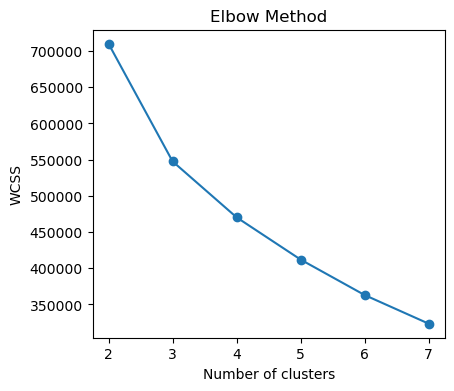

In [111]:
# Plot elbow curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(2,8), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [73]:
# Final clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_details['cluster'] = kmeans.fit_predict(pca_features)

## 6. Cluster Profiling

In [31]:
# Create a DataFrame of scaled features with cluster labels
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['cluster'] = customer_details['cluster']

In [57]:
print(scaled_df.shape)
print(scaled_df.info())

(196137, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196137 entries, 0 to 196136
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_count              196137 non-null  float64
 1   avg_days_between_orders  196137 non-null  float64
 2   weekend_order_ratio      196137 non-null  float64
 3   basket_size              196137 non-null  float64
 4   uniq_prod                196137 non-null  float64
 5   reorder_ratio            196137 non-null  float64
 6   Age                      196137 non-null  float64
 7   income                   196137 non-null  float64
 8   cluster                  196136 non-null  float64
dtypes: float64(9)
memory usage: 13.5 MB
None


In [31]:
# Calculate mean scaled values per cluster
scaled_profiles = scaled_df.groupby('cluster').mean().round(2)

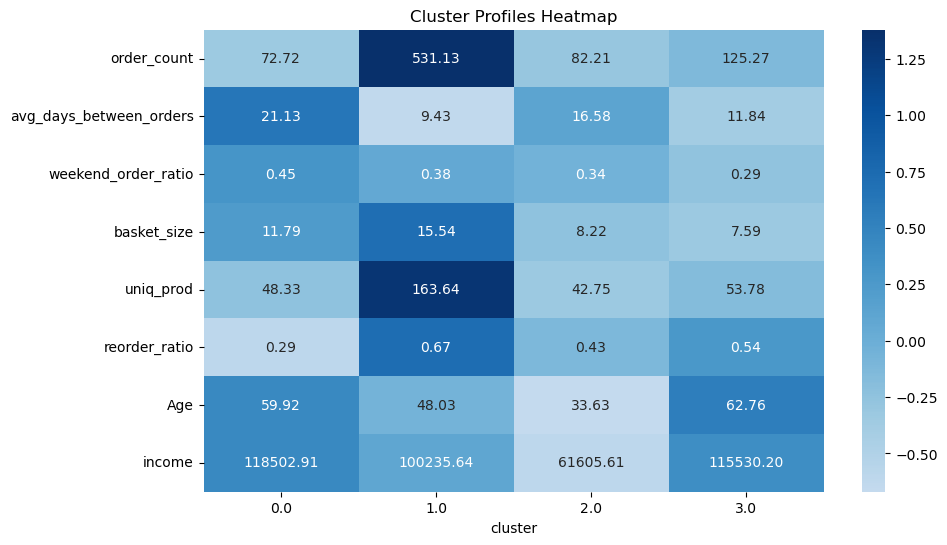

In [33]:
# Analyze cluster characteristics
cluster_profiles = customer_details.groupby('cluster').agg({
    'order_count':'mean',
    'avg_days_between_orders':'mean',
    'weekend_order_ratio':'mean',
    'basket_size':'mean',
    'uniq_prod':'mean',
    'reorder_ratio':'mean',
    'age':'mean',
    'income':'mean'
}).round(2)


# Visualize profiles
plt.figure(figsize=(10,6))
sns.heatmap(
    scaled_profiles.T,  # Use scaled values for coloring
    annot=cluster_profiles.T,  # Use original values for annotations
    cmap='Blues', 
    fmt='.2f',
    annot_kws={'size': 10},
    center=0  # Center color map at 0 (since data is standardized)
)
plt.title('Cluster Profiles Heatmap')
plt.show()

In [35]:
# Compare cluster sizes
print(customer_details['cluster'].value_counts().sort_index())

cluster
0    46484
1    31249
2    68864
3    49540
Name: count, dtype: int64


In [37]:
# Get top 2 departments per cluster
top_depts_per_cluster = (customer_details.groupby(['cluster', 'department'])
                         .size()
                         .reset_index(name='count')
                         .sort_values(['cluster', 'count'], ascending=[True, False])
                         .groupby('cluster')
                         .head(2))
# Pivot for clean presentation
result = (top_depts_per_cluster.pivot(index='cluster', 
                                    columns='department', 
                                    values='count')
                              .fillna('')
                              .apply(lambda x: x.sort_values(ascending=False).index[:2], axis=1)
                              .reset_index(name='top_departments'))

# Format output
result['top_departments'] = result['top_departments'].apply(lambda x: f"{x[0]}, {x[1]}")

print("Top 2 Departments per Cluster:")
print(result.to_markdown(index=False))

Top 2 Departments per Cluster:
|   cluster | top_departments     |
|----------:|:--------------------|
|         0 | produce, dairy eggs |
|         1 | produce, dairy eggs |
|         2 | produce, dairy eggs |
|         3 | produce, dairy eggs |


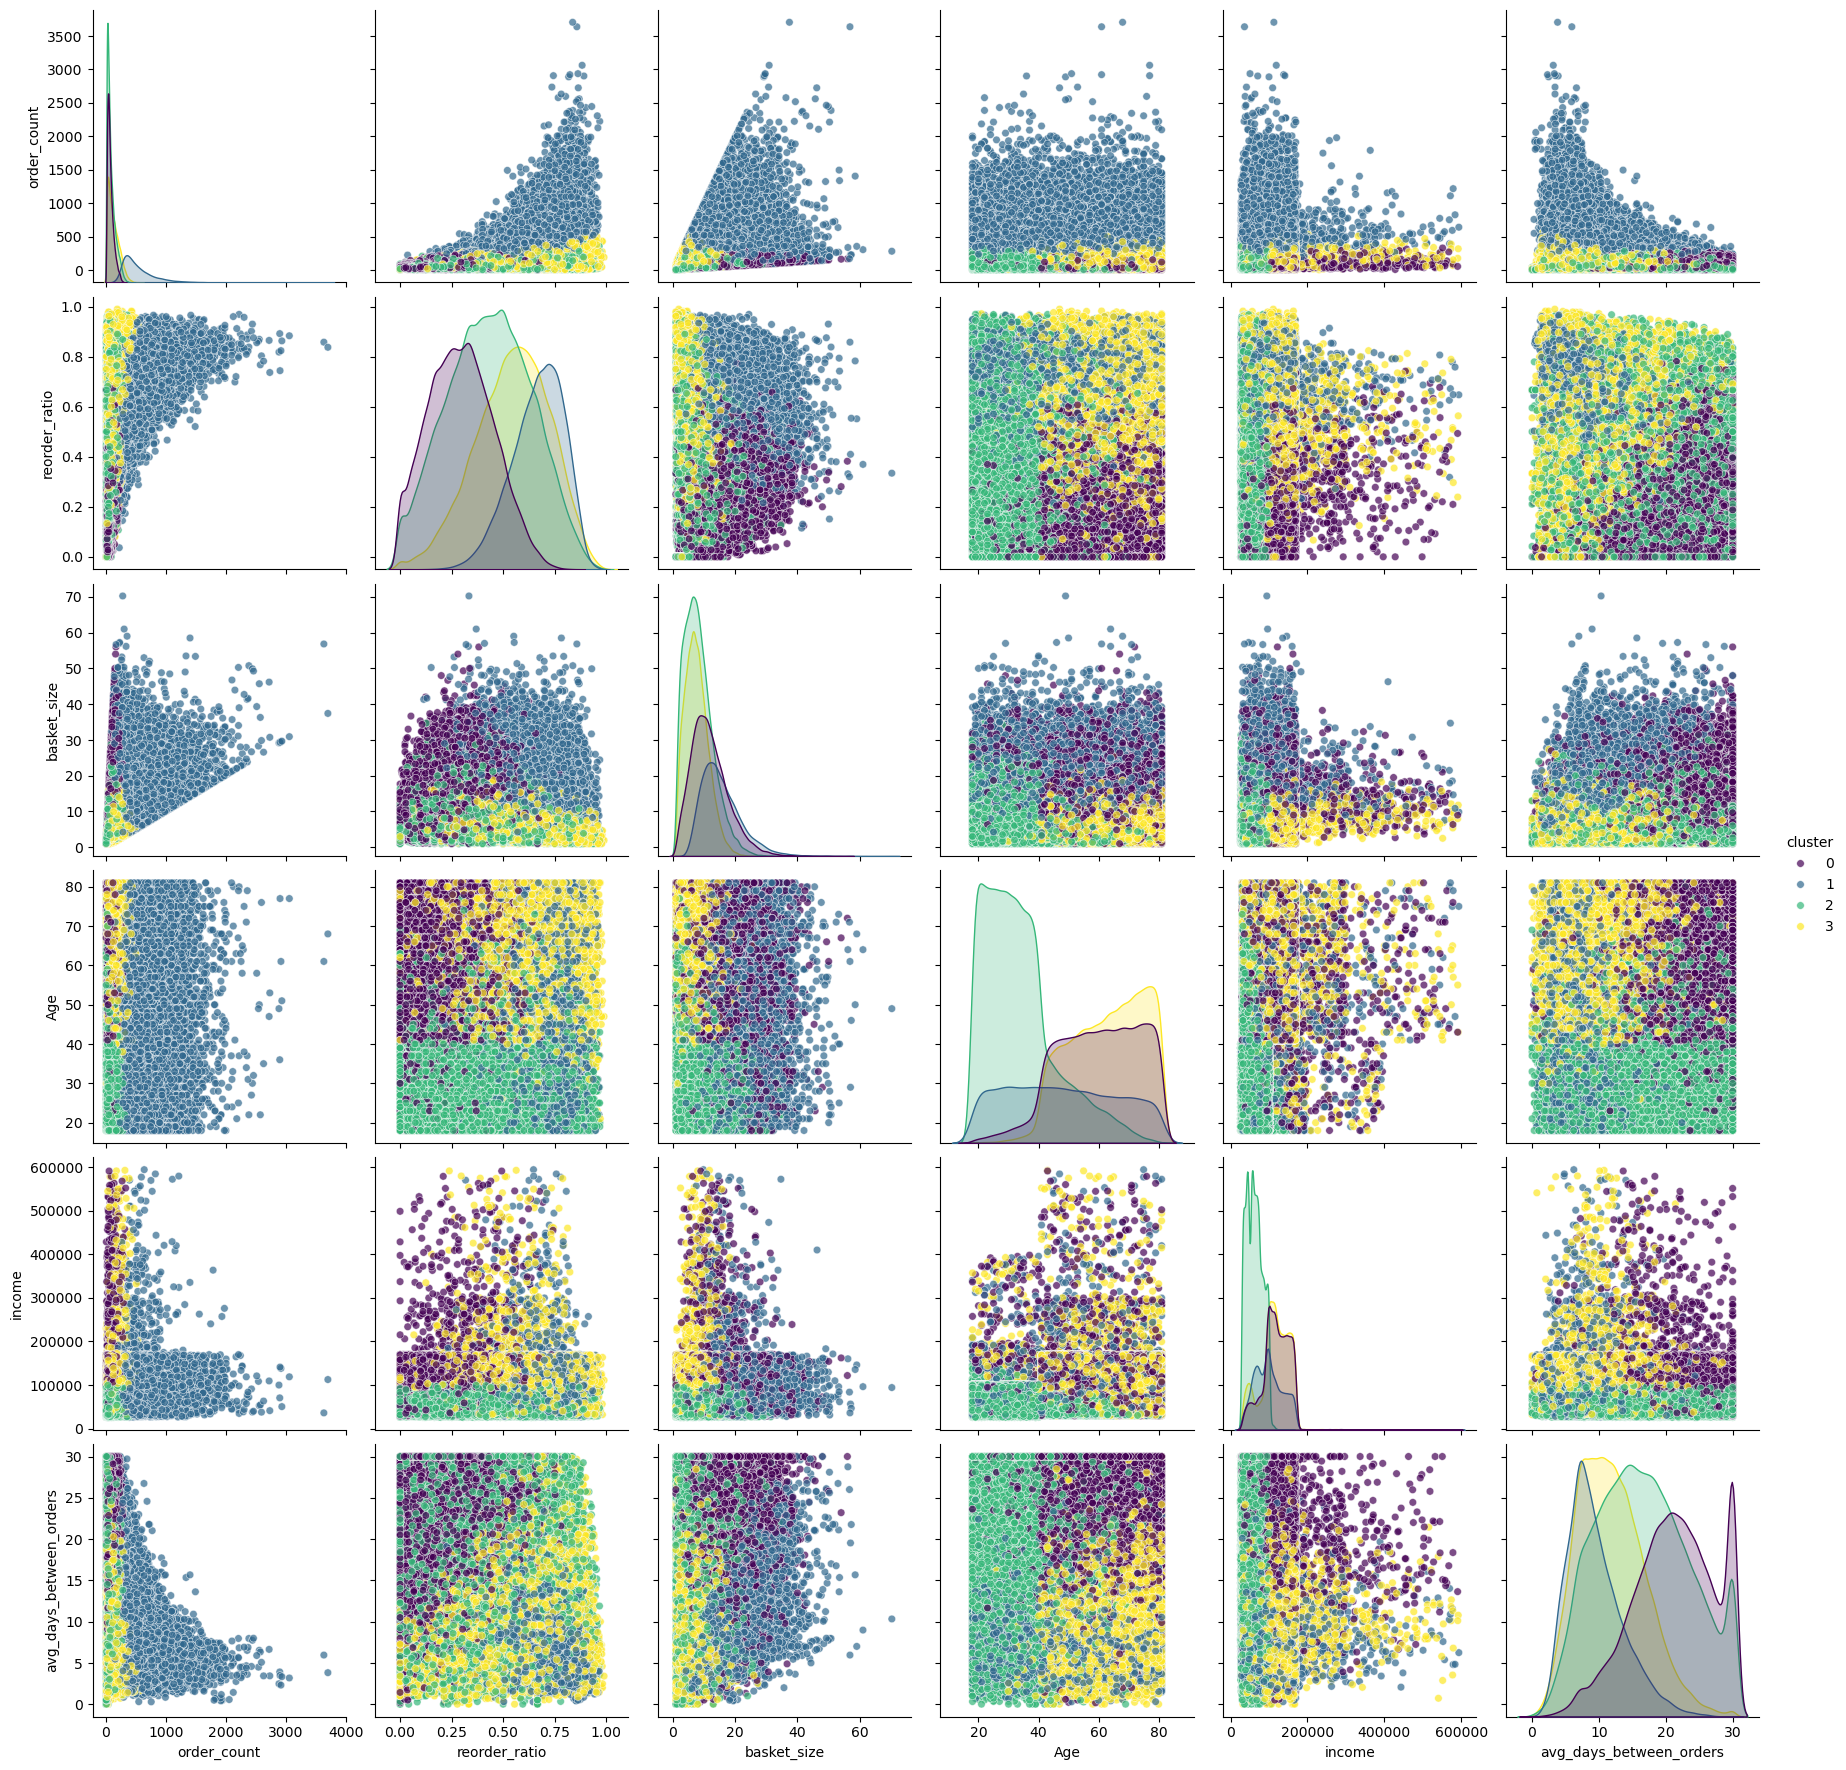

In [115]:
# Create pair plot
pair_plot = sns.pairplot(
    customer_details,
    vars=['order_count', 'reorder_ratio', 'basket_size', 'Age', 'income', 'avg_days_between_orders'],
    hue='cluster',
    palette='viridis',
    plot_kws={'alpha': 0.7, 's': 30},
    diag_kind='kde',
    height=3
)

## 7. Interactive 3D Visualization

In [ ]:
# Create interactive 3D plot to analyze variance directionality and cluster separability
fig = px.scatter_3d(
    x=pca_features[:,0], 
    y=pca_features[:,1], 
    z=pca_features[:,2],
    color=customer_details['cluster'],
    hover_name=customer_details['user_id'],
    title='Customer Segments in 3D PCA Space',
    labels={'0':'PC1', '1':'PC2', '2':'PC3'},
    width=800, height=600
)
fig.update_traces(marker_size=3)
fig.show()

## 8. Business Recommendations

In [197]:
# Define segment strategies
strategies = {

    0: {
        'name': 'Bulk Shoppers',
        'characteristics': 'Large baskets, infrequent orders, weekend shopper',
        'strategy': 'Volume discounts and bulk promotions'
    },
    1: {
        'name': 'Impulse Buyers',
        'characteristics': 'Frequent, large orders, diverse products',
        'strategy': 'New product recommendations'
    },
    2: {
        'name': 'Convenience Shoppers',
        'characteristics': 'Youngest cohort, small, less frequent orders, low planning',
        'strategy': 'Push notifications for quick reorders'
    },
    3: {

        'name': 'Meal Planners',
        'characteristics': 'High reorder ratio, small, consistent basket size',
        'strategy': 'Subscription program for staples'
    }
}

# Display recommendations
for cluster, strategy in strategies.items():
    print(f"\n**{strategy['name']} (Cluster {cluster})**")
    print(f"- Characteristics: {strategy['characteristics']}")
    print(f"- Recommended Strategy: {strategy['strategy']}")


**Bulk Shoppers (Cluster 0)**
- Characteristics: Large baskets, infrequent orders, weekend shopper
- Recommended Strategy: Volume discounts and bulk promotions

**Impulse Buyers (Cluster 1)**
- Characteristics: Frequent, large orders, diverse products
- Recommended Strategy: New product recommendations

**Convenience Shoppers (Cluster 2)**
- Characteristics: Youngest cohort, small, less frequent orders, low planning
- Recommended Strategy: Push notifications for quick reorders

**Meal Planners (Cluster 3)**
- Characteristics: High reorder ratio, small, consistent basket size
- Recommended Strategy: Subscription program for staples
